In [1]:
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
plt.rcParams['figure.figsize'] = (15, 7)
import pandas as pd
import numpy as np

### Import the dataset (from 6th march 2022 to 26 march 2022)

In [2]:
df = pd.read_csv('labelled_data_sample.csv')
df[['time']] = df[['time']].apply(pd.to_datetime)
df.rename(columns = {'Unnamed: 0':'x_column' }, inplace = True)

### Plotting the dataset 

C:\Users\user\Anaconda3\envs\usual\lib\site-packages\ipykernel_launcher.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  # This is added back by InteractiveShellApp.init_path()


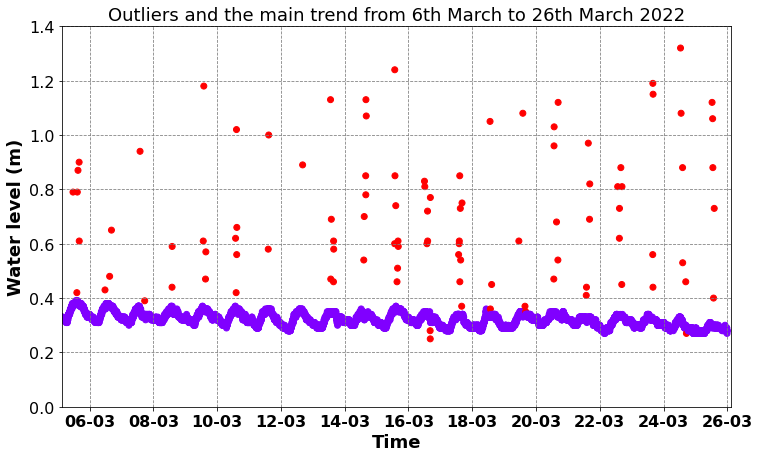

In [3]:
plt.rcParams['figure.figsize'] = (12, 7)
fig, ax = plt.subplots(1,1)
fig.patch.set_facecolor('white')
ax.scatter(df['time'],df['height'], c= df['datapoint_label'], cmap='rainbow')
ax.grid(color = 'gray', linestyle = '--', linewidth = 0.8)
ax.set_title('Outliers and the main trend from 6th March to 26th March 2022', fontsize=18)
ax.set_xlabel('Time', fontsize=18, weight = 'bold')
ax.set_ylabel('Water level (m)', fontsize=18, weight = 'bold')
ax.set_xlim(['2022-03-06 00:00:00'],['2022-03-26 23:59:59'])
ax.set_ylim(0, 1.4)
ax.set_xticklabels(df['time'], fontsize=16, weight='bold')
ax.tick_params(axis='y', labelsize=16)
ax.tick_params(axis='x',which='major', labelsize=16)

## Define the date format
date_form = DateFormatter("%d-%m")
ax.xaxis.set_major_formatter(date_form)
ax.set(facecolor = "white")

plt.show()

### Kernel density estimation 
To establish the unknown probability distribution of the water level data produced by the sensor.
This knowledge can be reveraged in getting of data points regarded to as anomalies.

#### The histogram 
To Determine the distribution of data samples.

1.32

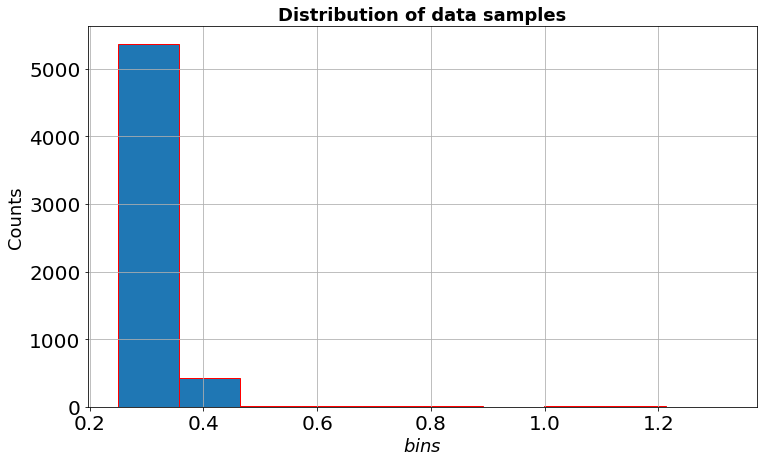

In [4]:
data_samples = np.array(df['height'])
plt.rcParams['figure.figsize'] = (12, 7)
plt.hist(data_samples, 10, edgecolor = 'Red');
plt.title('Distribution of data samples',fontsize=18,weight = 'bold')
plt.xlabel(r'$bins$', fontsize=18)
plt.ylabel('Counts', fontsize=18)
plt.tick_params(axis='both',labelsize=20,)
plt.tick_params(axis = 'x', labelsize = 20,)
#plt.yscale("log")
plt.grid(True)
max(data_samples)

### Kernel density estimation method (Sklearn) 
- fitting a known distribution to the data 
- kernel density from sklearn 

In [5]:
#KernelDensity from scikit learn
from sklearn.neighbors import KernelDensity
import numpy as np

### Silverman's Rule of thumb (NRD0) 
- if the data is unimodal but not symmetric


In [6]:
# bandwidth calculation
#calculate interquartile range 
q3, q1 = np.percentile(data_samples, [75 ,25])
iqr = q3 - q1
# calculate the standard deviation
strd = np.std(data_samples)
# calculate the bandwidth
h_band = 0.9 * min(iqr, strd) * (len(data_samples) ** -0.2) 
h_band

0.00634860814467009

### Silverman's Rule of thumb - Long tailed

In [7]:
h_band2 = 0.79 * iqr * (len(data_samples) ** -0.2)
h_band2

0.005572667149210412

In [8]:
kde = KernelDensity(kernel="gaussian", bandwidth = h_band).fit(data_samples.reshape(-1, 1))

In [9]:
data_sample_plot = np.linspace(np.min(data_samples),np.max(data_samples),100)
#log density
log_density = kde.score_samples(data_sample_plot.reshape(-1, 1))

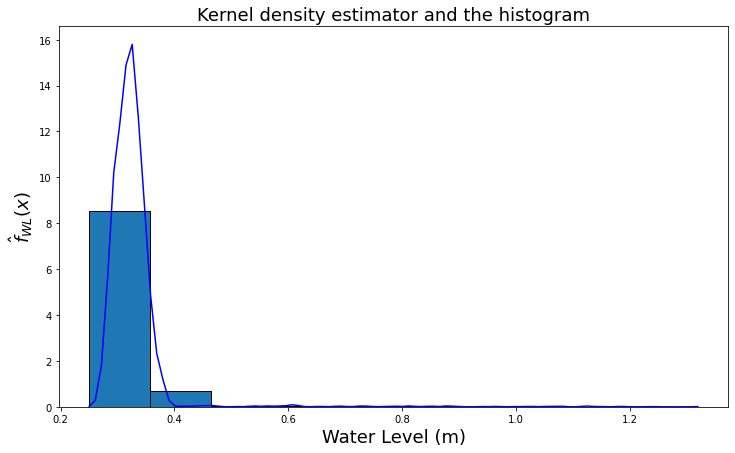

In [10]:
plt.hist(data_samples, 10, edgecolor = 'black', density=True);
plt.title('Kernel density estimator and the histogram', fontsize=18)
plt.xlabel('Water Level (m)', fontsize=18)
plt.ylabel(r'$\hat{f}_{WL}(x)$', fontsize=18)
plt.plot(data_sample_plot, np.exp(log_density), color = 'b')

### Anomaly detection using the suprise factor

In [86]:
# compute the suprise of the data points
surprise = -kde.score_samples(data_samples.reshape(-1, 1))
surprise_threshold = 1

In [87]:
surprise_index = list(surprise)
df['surprise_index'] = surprise_index

In [88]:
surprise_list = list(df['surprise_index'])
clusters =[]
for i in surprise_list:
    if i < surprise_threshold:
        cluster = 0
    else:
        cluster = 1
    clusters.append(cluster) 
    p = clusters

In [89]:
df['surprise_binary_index'] = p
df.to_csv ('kde_output.csv', header=True,index = False)

In [90]:
temp_df = df.loc[(df['surprise_binary_index'] == 0)]
df3 = temp_df.set_index('time')
df4 = df3.reset_index()

In [91]:
temp_df1 = df.loc[(df['surprise_binary_index'] == 1)]
df5 = temp_df1.set_index('time')
df6 = df5.reset_index()

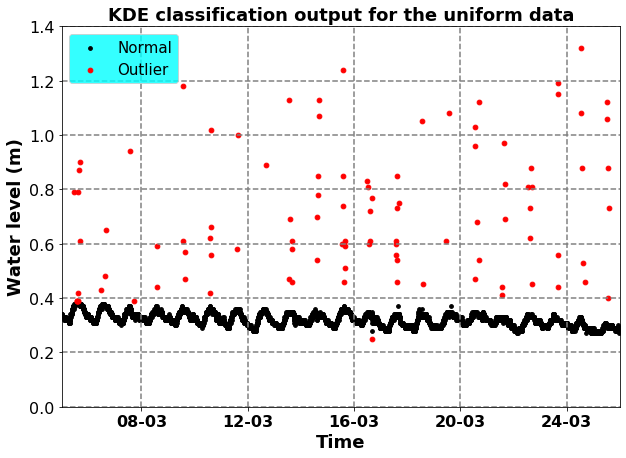

In [102]:
plt.rcParams['figure.figsize'] = (10, 7)
fig, ax = plt.subplots(1,1)
fig.patch.set_facecolor('white')
Normal = ax.scatter(df4['time'],df4['height'], c ="black", marker="o", s = 10**1.15)
Outlier = ax.scatter(df6['time'],df6['height'], c ="red",marker ="o", s = 10**1.35)
ax.grid(color = 'gray', linestyle = '--', linewidth = 1.5)
ax.set_title('KDE classification output for the uniform data', fontsize=18, weight='bold')
ax.set_xlabel('Time', fontsize=18, weight = 'bold')
ax.set_ylabel('Water level (m)', fontsize=18, weight = 'bold')
ax.set_xlim(['2022-03-5 20:59:59'],['2022-03-26 20:59:59'])
ax.set_ylim(0, 1.4)
ax.set_xticklabels(df['time'], fontsize=16, weight='bold')
ax.tick_params(axis='y', labelsize=16)
ax.tick_params(axis='x',which='major', labelsize=16)

## Define the date format
date_form = DateFormatter("%d-%m")
ax.xaxis.set_major_formatter(date_form)
ax.legend(["Normal", "Outlier"], loc ="upper left", fancybox=True,facecolor='#01FFFF',prop={'size': 15,  'style': 'normal'})
ax.set(facecolor = "white")
plt.savefig('kde_normal.png', dpi=450, orientation='portrait', bbox_inches='tight', facecolor='w',edgecolor='b',)
plt.show()

### Model metrics 

In [93]:
from sklearn.metrics import accuracy_score, f1_score,precision_score, recall_score, confusion_matrix, roc_curve, auc, ConfusionMatrixDisplay
data_labels = list(df['datapoint_label'])
kde_labels = list(df['surprise_binary_index'])

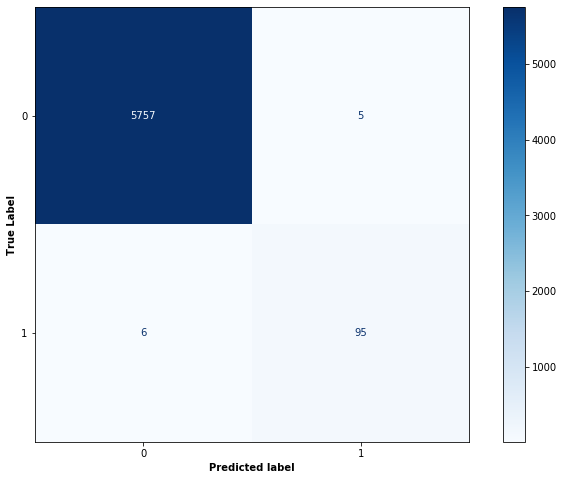

In [94]:
c_matrix = confusion_matrix (data_labels,kde_labels)
disp = ConfusionMatrixDisplay(c_matrix )
disp.plot(cmap=plt.cm.Blues,values_format='g',)
plt.xlabel('Predicted label', weight = 'bold')
plt.ylabel('True Label', weight = 'bold')


plt.savefig('con1.png', dpi=450, orientation='portrait', bbox_inches='tight', facecolor='w',edgecolor='b',)
plt.show()

In [95]:
data_accuracy = accuracy_score (data_labels,kde_labels)
data_accuracy

0.99812382739212

In [96]:
data_precision = precision_score (data_labels,kde_labels)
data_precision

0.95

In [97]:
data_recall_score = recall_score (data_labels,kde_labels)
data_recall_score

0.9405940594059405

In [98]:
data_f1_score = f1_score (data_labels,kde_labels)
data_f1_score

0.9452736318407959

In [50]:
x = ['Accuracy', 'Precision', 'Recall', 'F1_score']
y = [data_accuracy, data_precision, data_recall_score,data_f1_score ]

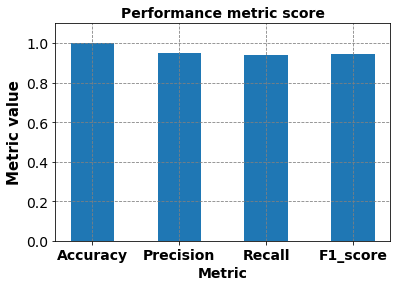

In [51]:
plt.rcParams['figure.figsize'] = (6, 4)
fig, ax = plt.subplots(1,1)
fig.patch.set_facecolor('white')
ax.bar(x, y, width=0.5)
ax.grid(color = 'gray', linestyle = '--', linewidth = 0.8)
ax.set_title('Performance metric score', fontsize=14, weight='bold')
ax.set_xlabel('Metric', fontsize=14, weight = 'bold')
ax.set_ylabel('Metric value', fontsize=15, weight = 'bold')
ax.set_ylim(0, 1.1)
ax.set_xticklabels(x, fontsize=12, weight='bold')
ax.tick_params(axis='y', labelsize=14)
ax.tick_params(axis='x',which='major', labelsize=14)

## Define the date format
ax.set(facecolor = "white")
plt.savefig('bar1.png', dpi=450, orientation='portrait', bbox_inches='tight', facecolor='w',edgecolor='b',)
plt.show()